# Fit spiking nonlinearity

## Set up

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import plotly.graph_objects as go
from scipy.signal import find_peaks
import scipy.io as sio
from sklearn import linear_model
from scipy.interpolate import interp1d
sns.set_style("white")

### Define functions to fit


In [2]:
def rectified_linear(Vm,threshold,slope):
    R = np.zeros(np.shape(Vm))

    R[Vm > threshold] = slope*(Vm[Vm > threshold] - threshold)

    return R

In [3]:
def sigmoid(x, a, b, c, d):
    f = a/(1 + np.exp(-b*(x - c)))
    f[x < d] = 0
    return f 

## Fit all neurons and compute adjusted $R^2$

In [4]:
!wget https://www.dropbox.com/s/rsu3tfpodjyrkgy/ICx_Spiking_NL_Dataset.mat?dl=0

--2021-07-08 20:46:05--  https://www.dropbox.com/s/rsu3tfpodjyrkgy/ICx_Spiking_NL_Dataset.mat?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rsu3tfpodjyrkgy/ICx_Spiking_NL_Dataset.mat [following]
--2021-07-08 20:46:05--  https://www.dropbox.com/s/raw/rsu3tfpodjyrkgy/ICx_Spiking_NL_Dataset.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc21c21398cd2727a77ddeea0624.dl.dropboxusercontent.com/cd/0/inline/BR5LlqW8Pj2weHp9wC-XGftxyHKW1t7t7kW3tLZ9jiq_Z8KGOR4Tyyod-gUf1hs_dgReE_1E2NkR3soRhUZAkv7WQXGniPeU1nBrZZ0oSPZOkfWbYVj0PbXivesxp8obz__CHPQ3mF-0Pv8N_bCVUDTO/file# [following]
--2021-07-08 20:46:06--  https://uc21c21398cd2727a77ddeea0624.dl.dropboxusercontent.com/cd/0/inline/BR5LlqW8Pj2weHp9wC-XGftxyHKW1t7t7kW3tLZ9jiq

In [5]:
#Get all spiking nonlinearity data
!wget https://www.dropbox.com/s/rsu3tfpodjyrkgy/ICx_Spiking_NL_Dataset.mat?dl=0

#Filename for all spiking nonlinearity data
filename = 'ICx_Spiking_NL_Dataset.mat?dl=0'

#The data are .mat files. Use scipy to load a file:
mat = sio.loadmat(filename, squeeze_me=True)
 
#First select the membrane potentials and spike count data:
MemPot = mat['Vm']
SpikeCount = mat['SC']

#Number of neurons
N = np.size(MemPot)

#Number of models
M = 2 

#Adjusted R^2
adj_r2 = np.zeros((N,M))

#Sigmoid parameter fits
sig_parms = np.zeros((N,4))

#Dynamic range
dyn_range = np.zeros(N)

for i in np.arange(N):
    
    #Get data for this neuron
    Vm = MemPot[i]
    SC = SpikeCount[i]
    
    #Remove nan's
    ind = np.isnan(Vm)
    Vm = Vm[~ind]
    SC = SC[~ind]
    
    #Fit rectified linear
    popt_RL, _ = curve_fit(rectified_linear, Vm, SC, bounds=([np.min(Vm), 0.], [np.max(Vm), 10*np.max(SC)/(np.max(Vm) - np.min(Vm))]))

    #Fit sigmoid
    p_init = [(np.max(SC)-np.min(SC))*2, 1, np.max(Vm), np.min(Vm)+1]
    p_min = [0, 0, np.min(Vm), np.min(Vm)]
    p_max = [(np.max(SC)-np.min(SC))*2, 10, np.max(Vm)+20, np.max(Vm)]
    
    popt_S, _ = curve_fit(sigmoid, Vm, SC, p0 = p_init, bounds = (p_min, p_max), maxfev=10000)
    
    sig_parms[i,:] = popt_S
    
    #Dynamic range
    dyn_range[i] = np.max(Vm) - popt_S[3]
    

    #Number of data points
    n = np.size(Vm)

    #Rectified linear
    k_RL = 2 #Number of parameters
    RL_pred = rectified_linear(Vm, *popt_RL)
    r2_RL = r2_score(SC, RL_pred) 
    adj_r2_RL = 1 - (1 - r2_RL)*(n - 1)/(n - k_RL - 1)

    #Sigmoid
    k_S = 4 #Number of parameters
    S_pred = sigmoid(Vm, *popt_S)
    r2_S = r2_score(SC, S_pred) 
    adj_r2_S = 1 - (1 - r2_S)*(n - 1)/(n - k_S - 1)

    adj_r2[i,:] = [adj_r2_RL, adj_r2_S]

--2021-07-08 20:46:07--  https://www.dropbox.com/s/rsu3tfpodjyrkgy/ICx_Spiking_NL_Dataset.mat?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rsu3tfpodjyrkgy/ICx_Spiking_NL_Dataset.mat [following]
--2021-07-08 20:46:07--  https://www.dropbox.com/s/raw/rsu3tfpodjyrkgy/ICx_Spiking_NL_Dataset.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6d7674538c527cc95fd8de02b0.dl.dropboxusercontent.com/cd/0/inline/BR48JsLeuovHEbFlj6E2flmjgy-F3hJ6bmhrACOKMWtTIEOmNtwW6WM9pFw_xVjPuZTQJvkjGQsH22p52qamXufsexGU5vPMNHKrRuk3Uxg8-watWtNhUR9VNO5tf__BAqIWLrEkHzhTjfseTEeF3Wd7/file# [following]
--2021-07-08 20:46:07--  https://uc6d7674538c527cc95fd8de02b0.dl.dropboxusercontent.com/cd/0/inline/BR48JsLeuovHEbFlj6E2flmjgy-F3hJ6bmhrACOKMWt

## Determine best fits

In [6]:
#Find ReLu models

ind_ReLu = np.where((adj_r2[:,0] >= np.max(adj_r2,axis = 1)))

print(ind_ReLu)
print(np.size(ind_ReLu))

(array([ 5,  9, 19, 20, 27]),)
5


In [7]:
#Find sigmoid models

ind_sig = np.where((adj_r2[:,1] >= np.max(adj_r2,axis = 1)))

print(ind_sig)
np.size(ind_sig)

(array([ 0,  1,  2,  3,  4,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       21, 22, 23, 24, 25, 26, 28, 29, 30, 31]),)


27

## Figure 2

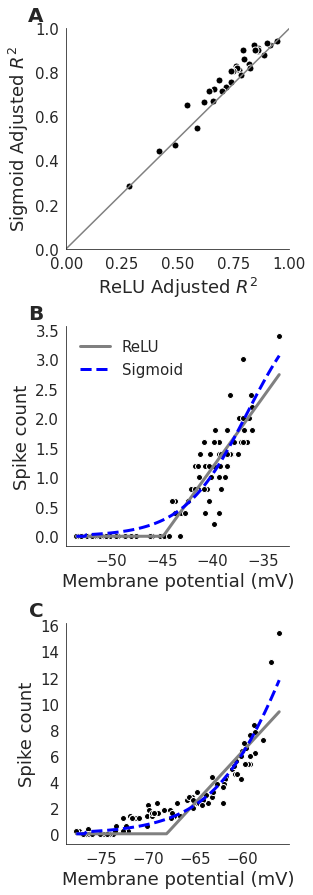

In [8]:
#neurons to use 
nrn_ind = [5, 30, 20]

plt.figure(figsize = (4,15))

labels = ('A', 'B', 'C', 'D')

for k in np.arange(2):
    
    #Select data for one neuron 
    n = nrn_ind[k]
    Vm = MemPot[n]
    SC = SpikeCount[n]
    
    #Remove nan's
    ind = np.isnan(Vm)
    Vm = Vm[~ind]
    SC = SC[~ind]

    #Fit rectified linear
    popt_RL, _ = curve_fit(rectified_linear, Vm, SC, bounds=([np.min(Vm), 0.], [np.max(Vm), 10*np.max(SC)/(np.max(Vm) - np.min(Vm))]))

    
    #Fit sigmoid
    p_init = [(np.max(SC)-np.min(SC))*2, 1, np.max(Vm), np.min(Vm)+1]
    p_min = [0, 0, np.min(Vm), np.min(Vm)]
    p_max = [(np.max(SC)-np.min(SC))*2, 10, np.max(Vm)+20, np.max(Vm)]

    popt_S, _ = curve_fit(sigmoid, Vm, SC, p0 = p_init, bounds = (p_min, p_max), maxfev=10000)
             
    #Plot fits
    v=np.linspace(np.min(Vm),np.max(Vm),100)
    
    #ax = plt.subplot(2,3,k+1)
    #ax = plt.subplot(4,1,k+2)
    ax = plt.subplot(3,1,k+2)
    
    ax.text(-0.1, 1.1, labels[k+1], transform=ax.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')
    
    plt.plot(Vm,SC,'ko',mec = 'w',mew = 1,ms = 6)
    plt.plot(v, rectified_linear(v, *popt_RL),'gray',label='ReLU',lw=3) #Plots a smooth curve
    plt.plot(v, sigmoid(v, *popt_S),'b--',label='Sigmoid',lw=3) #Plots a smooth curve

    plt.xlabel('Membrane potential (mV)',fontsize=18)
    plt.ylabel('Spike count',fontsize=18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    if k == 0:
        plt.legend(fontsize = 15, frameon = False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        

#Compare adjusted r^2         
ax = plt.subplot(3,1,1) 

ax.text(-0.1, 1.1, 'A', transform=ax.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')
    
plt.plot(adj_r2[:,0],adj_r2[:,1],'ko',mec = 'w',mew = 1,ms = 7)
x = np.linspace(0,1,100)
plt.plot(x,x,color = 'gray')

#Label the axes
plt.xlabel('ReLU Adjusted $R^2$',fontsize = 18)
plt.ylabel('Sigmoid Adjusted $R^2$',fontsize = 18)
plt.title(' ',fontsize = 20)
plt.tick_params(labelsize = 15)
plt.ylim(0,1)
plt.xlim(0,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.subplots_adjust(wspace = 0.5, hspace = 0.35)

#from google.colab import files
#files.download("Figure2.png") 

plt.show()


## Sigmoid fit parameters and dynamic range

In [9]:
sig_parms = np.round(sig_parms,2)
dyn_range = np.round(dyn_range,2)

fig = go.Figure(data=[go.Table(header=dict(values=['Cell','a', 'b', 'c', 'd', 'dynamic range']),
                 cells=dict(values=[np.arange(N),sig_parms[:,0], sig_parms[:,1], sig_parms[:,2], sig_parms[:,3], dyn_range]))
                     ])
fig.show()

## Plot fits for all neurons

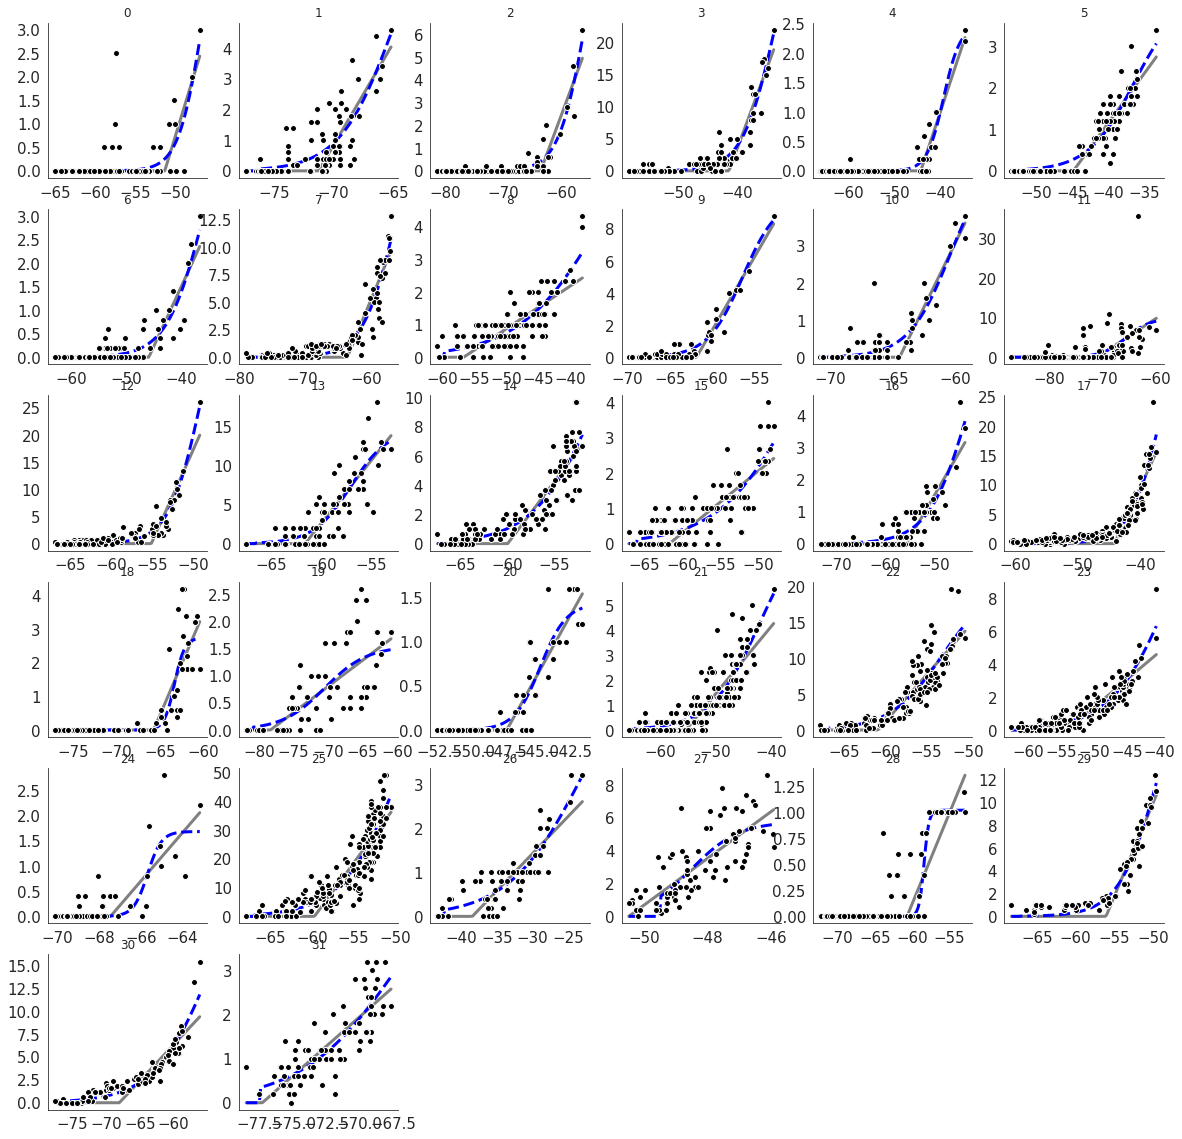

In [10]:
plt.figure(figsize = (20,20))

for k in np.arange(N):
    
    #Select data for one neuron 
    
    Vm = MemPot[k]
    SC = SpikeCount[k]
        
    #Remove nan's
    ind = np.isnan(Vm)
    Vm = Vm[~ind]
    SC = SC[~ind]
    
    #Fit rectified linear
    popt_RL, _ = curve_fit(rectified_linear, Vm, SC, bounds=([np.min(Vm), 0.], [np.max(Vm), 10*np.max(SC)/(np.max(Vm) - np.min(Vm))]))

    #Fit sigmoid
    p_init = [(np.max(SC)-np.min(SC))*2, 1, np.max(Vm), np.min(Vm)+1]
    p_min = [0, 0, np.min(Vm), np.min(Vm)]
    p_max = [(np.max(SC)-np.min(SC))*2, 3, np.max(Vm)+20, np.max(Vm)] #10
    
    popt_S, _ = curve_fit(sigmoid, Vm, SC, p0 = p_init, bounds = (p_min, p_max), maxfev=10000)

                

    #Plot fits
    v=np.linspace(np.min(Vm),np.max(Vm),100)
    
    ax = plt.subplot(6,6,k+1)
    
    #ax.text(-0.1, 1.1, labels[k], transform=ax.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')
    
    #plt.plot(Vm,SC,'ko',mec = 'w',mew = 1,label='data')
    plt.plot(v, rectified_linear(v, *popt_RL),'gray',label='rect-lin',lw=3) #Plots a smooth curve
    plt.plot(v, sigmoid(v, *popt_S),'b--',label='sigmoid',lw=3) #Plots a smooth curve

    plt.plot(Vm,SC,'ko',mec = 'w',mew = 1)
    #plt.xlabel('Membrane potential (mV)',fontsize=18)
    #plt.ylabel('Spike count',fontsize=18)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(str(k))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #if k == 1:
        #plt.xticks(np.arange(-70,-50,4))


## Table of adjusted $R^2$ values

In [11]:
#Make table of adjusted r-squared values

results = np.round(adj_r2,2)

fig = go.Figure(data=[go.Table(header=dict(values=['Cell','Rectified-Linear', 'Sigmoid']),
                 cells=dict(values=[np.arange(N),results[:,0], results[:,1]]))
                     ])
fig.show()